# Tutorial on Particle Smoothing Variational Objectives
## Setup

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import os
import numpy as np

np.warnings.filterwarnings('ignore')          # to avoid np deprecation warning
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"      # to avoid lots of log about the device
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'   # hack to avoid OS bug...

In [2]:
cwd = '../src/'
os.chdir(cwd)

In [3]:
from runner import main

In [4]:
print("the code is written in:")
print("\t tensorflow version: 1.12.0")
print("\t tensorflow_probability version: 0.5.0")

print("the system uses:")
print("\t tensorflow version:", tf.__version__)
print("\t tensorflow_probability version:", tfp.__version__)

the code is written in:
	 tensorflow version: 1.12.0
	 tensorflow_probability version: 0.5.0
the system uses:
	 tensorflow version: 1.12.0
	 tensorflow_probability version: 0.5.0


## Flags

### Data

In [5]:
# True: generate data set from simulation
# False: read data set from the file
generateTrainingData = False

datadir = '../data/fhn/[1,0]_obs_cov_0.01/'
datadict = 'datadict'

# Was the data pickled in Python2?
isPython2 = False

### Model Specification

In [6]:
Dx = 2  # dimension of hidden states
Dy = 1  # dimension of observations
poisson_emission = False  # emission probability is Poisson or Gaussian

### Training Hyperparameters

In [7]:
n_particles = 16
batch_size = 1
lr = 3e-3
epoch = 400
seed = 0

#### Optional Training Hyperparameters

In [8]:
# only will be used when generating data from simulation
# will be overwritten if loading data from the file
time = 200
n_train = 200 * batch_size
n_test = 40 * batch_size

In [9]:
# stop training early if validation set does not improve
early_stop_patience = 200

# reduce learning rate when testing loss doesn't improve for some time
lr_reduce_patience = 30

# the factor to reduce lr, new_lr = old_lr * lr_reduce_factor
lr_reduce_factor = 1 / np.sqrt(2)

# minimum lr
min_lr = lr / 10

### Networks

In [10]:
# Feed-Forward Network (FFN), number of units in each hidden layer
# For example, [64, 64] means 2 hidden layers, 64 neurons in each hidden layer
q0_layers = [32]        # proposal initial term q(x_1|y_1) or q(x_1|y_1:T)
q1_layers = [32]        # proposal evolution term q(x_t|x_{t-1}), including backward evolution term q(x_{t-1}|x_t)
q2_layers = [32]        # proposal encoding term q(x_t|y_t) or q(x_t|y_1:T)
f_layers = [32]         # target evolution
g_layers = [32]         # target emission

In [11]:
# Covariance Terms
q0_sigma_init, q0_sigma_min = 5, 1
q1_sigma_init, q1_sigma_min = 5, 1
q2_sigma_init, q2_sigma_min = 5, 1
f_sigma_init, f_sigma_min = 5, 1
g_sigma_init, g_sigma_min = 5, 1

In [12]:
# if q, f and g networks also output covariance (sigma)
output_cov = False

# if networks also output covariance, whether they only output diagonal value of cov matrix
diag_cov = False

In [13]:
# bidirectional RNN, number of units in each LSTM cells
# For example, [32, 32] means a bRNN composed of 2 LSTM cells, 32 units in each cell
y_smoother_Dhs = [32]
X0_smoother_Dhs = [32]

In [14]:
# whether use tf.contrib.rnn.stack_bidirectional_dynamic_rnn or tf.nn.bidirectional_dynamic_rnn for bRNN
# check https://stackoverflow.com/a/50552539 for differences between them
use_stack_rnn = True

# whether use a separate RNN for getting X0
X0_use_separate_RNN = True

### State Space Model Parameters

In [15]:
# whether q1 (evolution term in proposal) and f share the same network
# (Even if use_2_q == True, f and q1 can still use different networks)
use_bootstrap = True

# should q use true_X to sample particles? (useful for debugging)
q_uses_true_X = False

# Does proposal uses two networks q1(x_t|x_t-1) and q2(x_t|y_t)
# if True, q_uses_true_X will be overwritten as False
use_2_q = True

### Parameters for Inference Schemes

In [16]:
# Choose one of the following objectives
PSVO = True      # Particle Smoothing Variational Objective (use Forward Filtering Backward Simulation)
PSVOwR = False   # Particle Smoothing Variational Objective with Resampling
SVO = False      # Smoothing Variational Objective (use proposal based on bRNN)
AESMC = False    # Auto-Encoding Sequential Monte Carlo
IWAE = False     # Importance Weighted Auto-Encoder

#### Optional Parameters for Inference Schemes

In [17]:
# ----------------------- FFBSimulation flags----------------------- #
# number of subparticles sampled when augmenting the trajectory backwards
n_particles_for_BSim_proposal = 8

# whether Backward Simulation proposal use unidirectional RNN or bidirectional RNN (bRNN)
BSim_use_single_RNN = False

### Logging and Data Saving

In [18]:
# frequency to evaluate testing loss & other metrics and save results
print_freq = 10

# whether to save the followings during training
#   hidden trajectories
#   k-step y-hat
save_trajectory = True
save_y_hat = False

# dir to save all results
rslt_dir_name = "notebook"

# number of steps to predict y-hat and calculate R_square
MSE_steps = 30

# number of testing data used to save hidden trajectories, y-hat, gradient and etc
# will be clipped by number of testing data
saving_num = 30

# whether to save tensorboard
save_tensorboard = False

# whether to save model
save_model = False

## Pack Flags into ```tf.flags```

In [19]:
q0_layers = ",".join([str(x) for x in q0_layers])
q1_layers = ",".join([str(x) for x in q1_layers])
q2_layers = ",".join([str(x) for x in q2_layers])
f_layers = ",".join([str(x) for x in f_layers])
g_layers = ",".join([str(x) for x in g_layers])
y_smoother_Dhs = ",".join([str(x) for x in y_smoother_Dhs])
X0_smoother_Dhs = ",".join([str(x) for x in X0_smoother_Dhs])

flags = tf.app.flags

# --------------------- Training Hyperparameters --------------------- #

flags.DEFINE_integer("Dx", Dx, "dimension of hidden states")
flags.DEFINE_integer("Dy", Dy, "dimension of observations")

flags.DEFINE_integer("n_particles", n_particles, "number of particles")
flags.DEFINE_integer("batch_size", batch_size, "batch size")
flags.DEFINE_float("lr", lr, "learning rate")
flags.DEFINE_integer("epoch", epoch, "number of epoch")

flags.DEFINE_integer("seed", seed, "random seed for np.random and tf")


# ------------------------------- Data ------------------------------- #

flags.DEFINE_boolean("generateTrainingData", generateTrainingData, "True: generate data set from simulation; "
                                                                   "False: read data set from the file")
flags.DEFINE_string("datadir", datadir, "path of the data set file relative to the repository directory")
flags.DEFINE_string("datadict", datadict, "name of the data set file")
flags.DEFINE_boolean("isPython2", isPython2, "Was the data pickled in python 2?")


flags.DEFINE_integer("time", time, "number of timesteps for simulated data")
flags.DEFINE_integer("n_train", n_train, "number of trajactories for traning set")
flags.DEFINE_integer("n_test", n_test, "number of trajactories for testing set")


# ------------------------ Networks parameters ----------------------- #
# Feed-Forward Network (FFN) architectures
flags.DEFINE_string("q0_layers", q0_layers, "architecture for q0 network, int seperated by comma, "
                                            "for example: '50,50' ")
flags.DEFINE_string("q1_layers", q1_layers, "architecture for q1 network, int seperated by comma, "
                                            "for example: '50,50' ")
flags.DEFINE_string("q2_layers", q2_layers, "architecture for q2 network, int seperated by comma, "
                                            "for example: '50,50' ")
flags.DEFINE_string("f_layers",  f_layers,  "architecture for f network, int seperated by comma, "
                                            "for example: '50,50' ")
flags.DEFINE_string("g_layers",  g_layers,  "architecture for g network, int seperated by comma, "
                                            "for example: '50,50' ")

flags.DEFINE_float("q0_sigma_init", q0_sigma_init, "initial value of q0_sigma")
flags.DEFINE_float("q1_sigma_init", q1_sigma_init, "initial value of q1_sigma")
flags.DEFINE_float("q2_sigma_init", q2_sigma_init, "initial value of q2_sigma")
flags.DEFINE_float("f_sigma_init",  f_sigma_init,  "initial value of f_sigma")
flags.DEFINE_float("g_sigma_init",  g_sigma_init,  "initial value of g_sigma")

flags.DEFINE_float("q0_sigma_min", q0_sigma_min, "minimal value of q0_sigma")
flags.DEFINE_float("q1_sigma_min", q1_sigma_min, "minimal value of q1_sigma")
flags.DEFINE_float("q2_sigma_min", q2_sigma_min, "minimal value of q2_sigma")
flags.DEFINE_float("f_sigma_min",  f_sigma_min,  "minimal value of f_sigma")
flags.DEFINE_float("g_sigma_min",  g_sigma_min,  "minimal value of g_sigma")

flags.DEFINE_boolean("output_cov", output_cov, "whether q, f and g networks also output covariance (sigma)")
flags.DEFINE_boolean("diag_cov", diag_cov, "whether the networks only output diagonal value of cov matrix")

# bidirectional RNN
flags.DEFINE_string("y_smoother_Dhs", y_smoother_Dhs, "number of units for y_smoother birdectional RNNs, "
                                                      "int seperated by comma")
flags.DEFINE_string("X0_smoother_Dhs", X0_smoother_Dhs, "number of units for X0_smoother birdectional RNNs, "
                                                        "int seperated by comma")
flags.DEFINE_boolean("X0_use_separate_RNN", X0_use_separate_RNN, "whether use a separate RNN for getting X0")
flags.DEFINE_boolean("use_stack_rnn", use_stack_rnn, "whether use tf.contrib.rnn.stack_bidirectional_dynamic_rnn "
                                                     "or tf.nn.bidirectional_dynamic_rnn")

# ------------------------ State Space Model ------------------------- #
flags.DEFINE_boolean("use_bootstrap", use_bootstrap, "whether q1 and f share the same network, "
                                                     "(ATTENTION: even if use_2_q == True, "
                                                     "f and q1 can still use different networks)")
flags.DEFINE_boolean("q_uses_true_X", q_uses_true_X, "whether q1 uses true hidden states to sample")
flags.DEFINE_boolean("use_2_q", use_2_q, "whether q uses two networks q1(x_t|x_t-1) and q2(x_t|y_t), "
                                         "if True, q_uses_true_X will be overwritten as False")
flags.DEFINE_boolean("poisson_emission", poisson_emission, "whether emission uses Poisson distribution")

# ------------------------- Inference Schemes ------------------------ #

flags.DEFINE_boolean("PSVO", PSVO, "Particle Smoothing Variational Objective (use Forward Filtering Backward Simulation)")
flags.DEFINE_boolean("PSVOwR", PSVOwR, "Particle Smoothing Variational Objective with Resampling")
flags.DEFINE_boolean("SVO", SVO, "Smoothing Variational Objective (use proposal based on bRNN)")
flags.DEFINE_boolean("AESMC", AESMC, "Auto-Encoding Sequential Monte Carlo")
flags.DEFINE_boolean("IWAE", IWAE, "Importance Weighted Auto-Encoder")

flags.DEFINE_integer("n_particles_for_BSim_proposal", n_particles_for_BSim_proposal, "number of particles used for"
                                                                                     " each trajectory in "
                                                                                     "backward simulation proposal")
flags.DEFINE_boolean("BSim_use_single_RNN", BSim_use_single_RNN, "whether Backward Simulation proposal "
                                                                 "use unidirectional RNN or bidirectional RNN")

# ----------------------------- Training ----------------------------- #

flags.DEFINE_integer("early_stop_patience", early_stop_patience,
                     "stop training early if validation set does not improve for certain epochs")

flags.DEFINE_integer("lr_reduce_patience", lr_reduce_patience,
                     "educe learning rate when testing loss doesn't improve for some time")
flags.DEFINE_float("lr_reduce_factor", lr_reduce_factor,
                   "the factor to reduce learning rate, new_lr = old_lr * lr_reduce_factor")
flags.DEFINE_float("min_lr", min_lr, "minimum learning rate")

# --------------------- printing and data saving params --------------------- #

flags.DEFINE_integer("print_freq", print_freq, "frequency to evaluate testing loss & other metrics and save results")

flags.DEFINE_boolean("save_trajectory", save_trajectory, "whether to save hidden trajectories during training")
flags.DEFINE_boolean("save_y_hat", save_y_hat, "whether to save k-step y-hat during training")

flags.DEFINE_string("rslt_dir_name", rslt_dir_name, "dir to save all results")
flags.DEFINE_integer("MSE_steps", MSE_steps, "number of steps to predict y-hat and calculate R_square")
flags.DEFINE_integer("saving_num", saving_num, "number of testing data used to "
                                               "save hidden trajectories, y-hat, gradient and etc, "
                                               "will be clipped by number of testing data")

flags.DEFINE_boolean("save_tensorboard", save_tensorboard, "whether to save tensorboard")
flags.DEFINE_boolean("save_model", save_model, "whether to save model")

FLAGS = flags.FLAGS

finished preparing dataset
Experiment_params:
	AESMC: False
	BSim_use_single_RNN: False
	Dx: 2
	Dy: 1
	IWAE: False
	MSE_steps: 30
	PSVO: True
	PSVOwR: False
	SVO: False
	X0_smoother_Dhs: 32
	X0_use_separate_RNN: True
	batch_size: 1
	datadict: datadict
	datadir: ../data/fhn/[1,0]_obs_cov_0.01/
	diag_cov: False
	early_stop_patience: 200
	epoch: 400
	f_layers: 32
	f_sigma_init: 5.0
	f_sigma_min: 1.0
	g_layers: 32
	g_sigma_init: 5.0
	g_sigma_min: 1.0
	generateTrainingData: False
	isPython2: False
	lr: 0.003
	lr_reduce_factor: 0.7071067811865475
	lr_reduce_patience: 30
	min_lr: 0.00030000000000000003
	n_particles: 16
	n_particles_for_BSim_proposal: 8
	n_test: 40
	n_train: 200
	output_cov: False
	poisson_emission: False
	print_freq: 10
	q0_layers: 32
	q0_sigma_init: 5.0
	q0_sigma_min: 1.0
	q1_layers: 32
	q1_sigma_init: 5.0
	q1_sigma_min: 1.0
	q2_layers: 32
	q2_sigma_init: 5.0
	q2_sigma_min: 1.0
	q_uses_true_X: False
	rslt_dir_name: notebook
	save_model: False
	save_tensorboard: False
	save_t

epoch 51   took 110.230 seconds
epoch 52   took 108.071 seconds
epoch 53   took 106.343 seconds
epoch 54   took 107.826 seconds
epoch 55   took 108.515 seconds
epoch 56   took 109.947 seconds
epoch 57   took 110.547 seconds
epoch 58   took 106.869 seconds
epoch 59   took 106.998 seconds

iter 60
Train log_ZSMC: -389.093, valid log_ZSMC: -390.689
Train, Valid k-step Rsq:
 [ 0.96218881  0.94139828  0.87684856  0.76664588  0.60937837  0.40710813
  0.16507047 -0.10798264 -0.40169346 -0.70634437 -1.01304913 -1.31559372
 -1.60904217 -1.89055324 -2.15769911 -2.40853381 -2.64147091 -2.85488319
 -3.04611588 -3.21287441 -3.35239077 -3.46118927 -3.53472471 -3.56867409
 -3.55774498 -3.49686003 -3.38438749 -3.22155905 -3.01360178 -2.76983142
 -2.49829578] 
 [ 0.95755335  0.93183655  0.85528526  0.72647071  0.54448041  0.31176937
  0.03396267 -0.27796543 -0.61207271 -0.9563787  -1.30172586 -1.64031291
 -1.96762848 -2.28133059 -2.57769203 -2.8576138  -3.11882782 -3.35944271
 -3.57714176 -3.76839209 -

epoch 120  took 157.330 seconds
epoch 121  took 103.942 seconds
epoch 122  took 103.261 seconds
epoch 123  took 103.003 seconds
epoch 124  took 102.593 seconds
epoch 125  took 102.862 seconds
epoch 126  took 102.590 seconds
epoch 127  took 103.464 seconds
epoch 128  took 103.728 seconds
epoch 129  took 103.551 seconds

iter 130
Train log_ZSMC: -384.596, valid log_ZSMC: -384.168
Train, Valid k-step Rsq:
 [ 9.68340695e-01  9.56595704e-01  9.25450265e-01  8.66642758e-01
  7.73589909e-01  6.40635908e-01  4.65080321e-01  2.49450028e-01
  6.34133816e-04 -2.70653725e-01 -5.51140785e-01 -8.30083251e-01
 -1.09902287e+00 -1.35513282e+00 -1.59687662e+00 -1.82277226e+00
 -2.03088593e+00 -2.22128057e+00 -2.39402652e+00 -2.54740930e+00
 -2.68180442e+00 -2.79544258e+00 -2.88379025e+00 -2.94650960e+00
 -2.97679853e+00 -2.96984744e+00 -2.92082715e+00 -2.82760143e+00
 -2.68964195e+00 -2.51065183e+00 -2.29713988e+00] 
 [ 0.96464636  0.95170881  0.9163112   0.84931803  0.74354973  0.59205386
  0.3927477  

epoch 190  took 157.112 seconds
epoch 191  took 103.473 seconds
epoch 192  took 103.874 seconds
epoch 193  took 102.700 seconds
epoch 194  took 103.494 seconds
epoch 195  took 102.978 seconds
epoch 196  took 102.919 seconds
epoch 197  took 102.551 seconds
epoch 198  took 102.952 seconds
epoch 199  took 102.421 seconds

iter 200
Train log_ZSMC: -362.309, valid log_ZSMC: -362.457
Train, Valid k-step Rsq:
 [0.98372863 0.98316542 0.98254424 0.98200473 0.98159614 0.98149439
 0.98161237 0.98159321 0.98150051 0.98104942 0.97995    0.97814658
 0.9753463  0.97167591 0.9673297  0.9625067  0.95724518 0.95194491
 0.94652611 0.94072457 0.93469271 0.92884637 0.92341585 0.91863596
 0.91561022 0.91443661 0.91461236 0.91606706 0.91859661 0.92208501
 0.92636696] 
 [0.98126783 0.98066775 0.97997697 0.97927119 0.9789376  0.97892441
 0.97918873 0.97943737 0.97934172 0.978846   0.97763331 0.97570296
 0.97316601 0.96959775 0.96540727 0.9609599  0.95597551 0.95065386
 0.94481146 0.93834347 0.93157867 0.924575

epoch 264  took 102.023 seconds
epoch 265  took 102.363 seconds
epoch 266  took 102.454 seconds
epoch 267  took 103.392 seconds
epoch 268  took 102.473 seconds
epoch 269  took 102.234 seconds

iter 270
Train log_ZSMC: -373.852, valid log_ZSMC: -369.623
Train, Valid k-step Rsq:
 [0.97895654 0.98026359 0.98095458 0.98130363 0.98124386 0.98114965
 0.98109412 0.98100701 0.981042   0.98092785 0.98046704 0.97979949
 0.97873819 0.97759998 0.97604257 0.97412129 0.97180755 0.96879169
 0.96538992 0.96143877 0.95729009 0.9533393  0.94957462 0.94559799
 0.9411191  0.93671758 0.93251517 0.92818402 0.92403262 0.92036999
 0.91705018] 
 [0.9769656  0.97839644 0.97927492 0.97964349 0.97978649 0.97980452
 0.97966755 0.97939745 0.97904188 0.97852824 0.97769876 0.9765212
 0.97502307 0.97369871 0.97202023 0.97011995 0.96794624 0.96501695
 0.96157368 0.95746561 0.95288553 0.94839944 0.94414243 0.93949721
 0.93434738 0.92924307 0.92452741 0.91917901 0.9138749  0.90972895
 0.90570324]
best valid cost on iter:

epoch 338  took 101.806 seconds
epoch 339  took 101.711 seconds

iter 340
Train log_ZSMC: -371.914, valid log_ZSMC: -372.919
Train, Valid k-step Rsq:
 [0.98490158 0.98525605 0.9852874  0.98518514 0.98493884 0.98477266
 0.98471246 0.98469423 0.98488582 0.9850539  0.98519107 0.9851982
 0.98505712 0.98471718 0.98427751 0.98384057 0.98332766 0.98284448
 0.98239569 0.98216995 0.98199056 0.98186304 0.98194472 0.98226731
 0.98263073 0.98320702 0.98381158 0.9842582  0.98457047 0.98474697
 0.98479396] 
 [0.98064588 0.98085856 0.98071196 0.98038129 0.98012445 0.97986844
 0.97973727 0.97993737 0.98022938 0.98053682 0.98089659 0.98136936
 0.98165711 0.98203978 0.98212923 0.98202315 0.9817845  0.98144772
 0.98105641 0.98079188 0.98063113 0.98058111 0.98067452 0.98085611
 0.98107907 0.98137661 0.98177489 0.9818279  0.98198419 0.98195864
 0.98175093]
best valid cost on iter: 190

valid cost not improving. reduce learning rate to 0.00030000000000000003
epoch 340  took 154.564 seconds
epoch 341  took 1

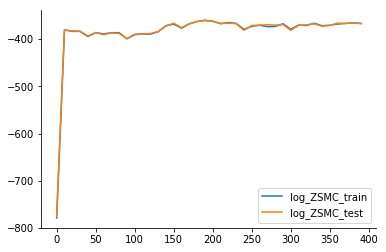

SystemExit: 

F:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [20]:
tf.app.run()

## Results

In [22]:
# get the dir storing results
import os
def all_subdirs_of(b='.'):
    result = []
    for d in os.listdir(b):
        bd = os.path.join(b, d)
        if os.path.isdir(bd): result.append(bd)
    return result
rslt_dirs = all_subdirs_of(os.path.join('rslts', rslt_dir_name))
rslt_dir = max(rslt_dirs, key=os.path.getmtime)
epoch_data_dirs = all_subdirs_of(os.path.join(os.path.join('rslts', 'epoch_data'), rslt_dir_name))
epoch_data_dir = max(epoch_data_dirs, key=os.path.getmtime)
print("Result Directory: {}".format(rslt_dir))
print("Epoch Data Directory: {}".format(epoch_data_dir))

Result Directory: rslts\notebook\D191011_212920_np_16_t_200_bs_1_lr_0.003_epoch_400_seed_0
Epoch Data Directory: rslts\epoch_data\notebook\D191011_212920_np_16_t_200_bs_1_lr_0.003_epoch_400_seed_0


#### ELBO across epochs

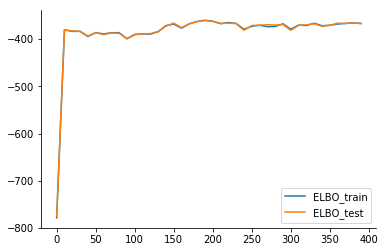

In [23]:
import json
import seaborn as sns
import matplotlib.pyplot as plt

with open(os.path.join(rslt_dir, "history.json"), "r") as f:
    history = json.load(f)
ELBO_train = history["log_ZSMC_trains"]
ELBO_test  = history["log_ZSMC_tests"]
epochs = np.arange(len(ELBO_test)) * print_freq
plt.figure()
plt.plot(epochs, ELBO_train)
plt.plot(epochs, ELBO_test)
plt.legend(["ELBO_train", "ELBO_test"])
sns.despine()
plt.show()

#### Learned dynamics and inferred hidden states

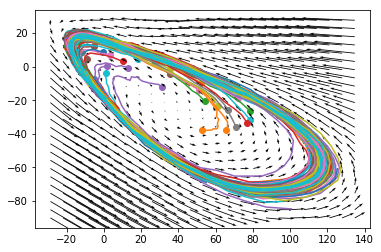

In [26]:
import pickle

def all_lattice_of(b='.'):
    result = []
    for d in os.listdir(b):
        bd = os.path.join(b, d)
        if "lattice" in d: result.append(bd)
    return result

lattice_data_dirs = all_lattice_of(epoch_data_dir)
lattice_data_fname = max(lattice_data_dirs, key=os.path.getmtime)
with open(lattice_data_fname, "rb") as f:
    lattice_dict = pickle.load(f)
X_trajs = lattice_dict["X_trajs"]
X = lattice_dict["X"]
nextX = lattice_dict["nextX"]

plt.figure()
for X_traj in X_trajs[0:saving_num]:
    plt.plot(X_traj[:, 0], X_traj[:, 1])
    plt.scatter(X_traj[0, 0], X_traj[0, 1])

axes = plt.gca()
x1range, x2range = axes.get_xlim(), axes.get_ylim()
scale = int(5 / 3 * max(abs(x1range[0]) + abs(x1range[1]), abs(x2range[0]) + abs(x2range[1])))
plt.quiver(X[:, :, 0], X[:, :, 1], nextX[:, :, 0] - X[:, :, 0], nextX[:, :, 1] - X[:, :, 1], scale=scale)

#### k-step R-sqaure

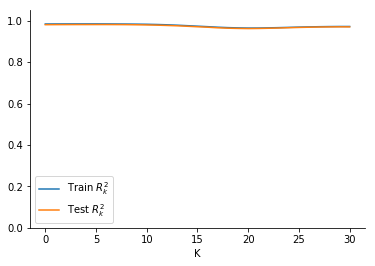

In [28]:
def all_metric_of(b='.'):
    result = []
    for d in os.listdir(b):
        bd = os.path.join(b, d)
        if "metric" in d: result.append(bd)
    return result

metric_data_dirs = all_metric_of(epoch_data_dir)
metric_data_fname = max(metric_data_dirs, key=os.path.getmtime)

with open(metric_data_fname, "rb") as f:
    metric_dict = pickle.load(f)
R_square_train, R_square_test = metric_dict["R_square_train"], metric_dict["R_square_test"]
plt.figure()
plt.plot(R_square_train)
plt.plot(R_square_test)
plt.ylim([0.0, 1.05])
plt.xlabel("K")
plt.legend(["Train $R^2_k$", "Test $R^2_k$"], loc='best')
sns.despine()
plt.show()